<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/02_download_metro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO:**

Extract the station building footprints:
1. There might some buildings that are not tagged as "train_station" or "transportation"
2. Try to query the buildings from overture maps and using a spatial filter extract the station building only.
3. Use fme for this purpose.

If this doesnot work then simply download the nodes from:
1. https://themetrorailguy.com/
2. Also the lines.

## Install Dependencies and Import Modules

In [59]:
!pip install -q osmnx
!pip install -q pydeck
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.6 MB/s eta 0:00:00


In [60]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


Deploy FastAPI apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


## Download OSM Data

In [4]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

## Functions


In [47]:
def create_map(W,S,E,N, Layer=None):
    bbox_geom = shapely.geometry.box(W,S,E,N)
    boundary_json = eval(gpd.GeoSeries(bbox_geom).to_json())

    boundary_layer = pdk.Layer(
        "GeoJsonLayer",
        boundary_json,
        opacity=1,
        stroked=True,
        filled=False,
        get_line_color=[100, 0, 0]
    )
    if Layer is not None:
        layer = pdk.Layer(
            "GeoJsonLayer",
            Layer,
            opacity=1,
            stroked=True,
            filled=True,
            get_fill_color=[100, 200, 0],
            get_line_color=[0,100,0],
            pickable=True
        )
        layers = [boundary_layer, layer]
    else:
        layers = [boundary_layer]


    C = bbox_geom.centroid
    view_state = pdk.ViewState(latitude=C.y, longitude=C.x, zoom=11, bearing=0, pitch=45)
    # Render

    r = pdk.Deck(layers=layers, initial_view_state=view_state, tooltip = True)
    return r

## Download Data

In [49]:
%%time
city = 'Delhi_NCR'
W,S,E,N = bboxs[city]
public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'public_transport':'station'}).reset_index()
print("Number of features found:", public_transport.shape[0])
public_transport[['name', 'public_transport']].head()

Number of features found: 394
CPU times: user 1.3 s, sys: 11.2 ms, total: 1.31 s
Wall time: 5.4 s


,name,public_transport
0,Sikanderpur,station
1,Delhi Aerocity,station
2,Hauz Khas (Yellow Line),station
3,Delhi Safdarjang,station
4,Sewa Nagar,station


In [50]:
public_transport['element_type'].value_counts()

element_type
node    331
way      63
Name: count, dtype: int64

In [57]:
public_transport = public_transport.set_crs('EPSG:4326')
relation = public_transport[public_transport['element_type']!='node'].copy()
nodes = public_transport[public_transport['element_type']=='node'].copy()
nodes['geometry'] = nodes['geometry'].to_crs('EPSG:4326').buffer(distance=1e-4, cap_style='square').to_crs('EPSG:4326')

gdf_final = pd.concat([relation, nodes])
gdf_final = nodes[['public_transport','geometry']].fillna("NA")
print("Total number of stations:", gdf_final.shape[0])
gdf_final.sample(3)

Total number of stations: 331


<ipython-input-57-865726a8f1d3>:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nodes['geometry'] = nodes['geometry'].to_crs('EPSG:4326').buffer(distance=1e-4, cap_style='square').to_crs('EPSG:4326')


,public_transport,geometry
161,station,"POLYGON ((77.07410 28.68198, 77.07410 28.68178..."
154,station,"POLYGON ((77.15539 28.67170, 77.15539 28.67150..."
207,station,"POLYGON ((77.20094 28.64813, 77.20094 28.64793..."


In [58]:
layer = eval(gdf_final.to_json())
create_map(W,S,E,N, layer)

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.604102500000003,
    "longitude": 77.24305950000002,
    "pitch": 45,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "bbox": [
          76.881197,
          28.31444,
          77.604922,
          28.893765
        ],
        "features": [
          {
            "bbox": [
              76.881197,
              28.31444,
              77.604922,
              28.893765
            ],
            "geometry": {
              "coordinates": [
                [
                  [
                    77.604922,
                    28.31444
                  ],
                  [
                    77.604922,
                    28.893765
                  ],
                  [
                    76.881197,
                    28.893765
                  ],
                  [
                    76.881197,
                    28.31444
                  ],
                  [
                    77.604922,
                    28.31444
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {},
            "type": "Feature"
          }
        ],
        "type": "FeatureCollection"
      },
      "filled": false,
      "getLineColor": [
        100,
        0,
        0
      ],
      "id": "d3e1a10d-8302-4053-975f-252fec5781a1",
      "opacity": 1,
      "stroked": true
    },
    {
      "@@type": "GeoJsonLayer",
      "data": {
        "features": [
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    77.0931017,
                    28.4813716
                  ],
                  [
                    77.0931017,
                    28.4811716
                  ],
                  [
                    77.0929017,
                    28.4811716
                  ],
                  [
                    77.0929017,
                    28.4813716
                  ],
                  [
                    77.0931017,
                    28.4813716
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "0",
            "properties": {
              "public_transport": "station"
            },
            "type": "Feature"
          },
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    77.12089490000001,
                    28.5488786
                  ],
                  [
                    77.12089490000001,
                    28.5486786
                  ],
                  [
                    77.1206949,
                    28.5486786
                  ],
                  [
                    77.1206949,
                    28.5488786
                  ],
                  [
                    77.12089490000001,
                    28.5488786
                  ]
                ]
              ],
              "type": "Polygon"
            },
            "id": "1",
            "properties": {
              "public_transport": "station"
            },
            "type": "Feature"
          },
          {
            "geometry": {
              "coordinates": [
                [
                  [
                    77.2068072,
                    28.544356399999998
                  ],
                  [
                    77.2068072,
                    28.5441564
                  ],
                  [
                    77.2066072,
                    28.5441564
                  ],
                  [
                    77.2066072,
                    28.544356399999998
                  ],
                  [
                    77.2068072,
                    28.544356399999998
                  ]
                ]
              ],
              "type": "Polygon"
            },
   

## Download Builing Data

In [62]:
%sql duckdb:///:memory:

Connecting to 'duckdb:///:memory:'

In [63]:
%%sql

INSTALL httpfs;
INSTALL spatial;

Running query in 'duckdb:///:memory:'

Success


{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'public_transport': 'station'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[77.0931017, 28.4813716],
      [77.0931017, 28.4811716],
      [77.0929017, 28.4811716],
      [77.0929017, 28.4813716],
      [77.0931017, 28.4813716]]]}},
  {'id': '1',
   'type': 'Feature',
   'properties': {'public_transport': 'station'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[77.12089490000001, 28.5488786],
      [77.12089490000001, 28.5486786],
      [77.1206949, 28.5486786],
      [77.1206949, 28.5488786],
      [77.12089490000001, 28.5488786]]]}},
  {'id': '2',
   'type': 'Feature',
   'properties': {'public_transport': 'station'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[77.2068072, 28.544356399999998],
      [77.2068072, 28.5441564],
      [77.2066072, 28.5441564],
      [77.2066072, 28.544356399999998],
      [77.2068072, 28.544356399999998]]]}},
  {'id': '3',

In [67]:
%%time

%%sql
LOAD spatial;
LOAD httpfs;

SELECT
    id,
    geometry
FROM read_parquet('s3://overturemaps-us-west-2/release/2024-06-13-beta.0/theme=buildings/type=*/*', filename=true, hive_partitioning=1)
WHERE
    bbox.xmin > 72.837646
    AND bbox.xmax < 72.874038
    AND bbox.ymin > 19.225295
    AND bbox.ymax < 19.2592;

Running query in 'duckdb:///:memory:'

RuntimeError: (duckdb.duckdb.Error) KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.10/dist-packages/traitlets/traitlets.py(1268): __new__
  /usr/local/lib/python3.10/dist-packages/duckdb_engine/__init__.py(139): execute
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/default.py(924): do_execute
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/base.py(1970): _exec_single_context
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/base.py(1849): _execute_context
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/base.py(1643): _execute_clauseelement
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/sql/elements.py(514): _execute_on_connection
  /usr/local/lib/python3.10/dist-packages/sqlalchemy/engine/base.py(1421): execute
  /usr/local/lib/python3.10/dist-packages/sql/connection/connection.py(767): _execute_with_parameters
  /usr/local/lib/python3.10/dist-packages/sql/connection/connection.py(862): _execute_with_error_handling

<Axes: >

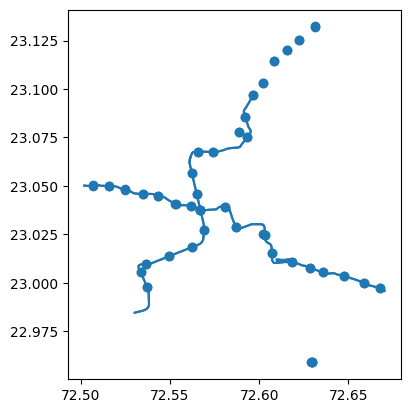

In [ ]:
ax= public_transport[public_transport['railway']=='subway'].plot()
public_transport[public_transport['railway']=='stop'].plot(ax=ax)

<Axes: >

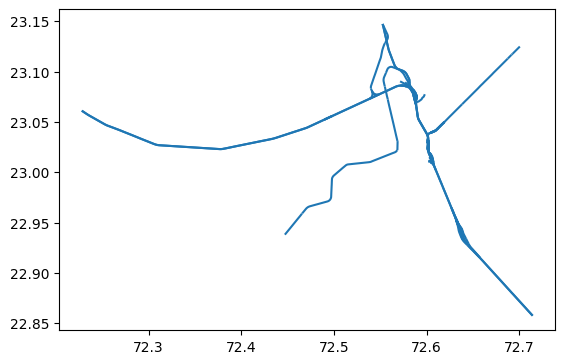

In [ ]:
public_transport[public_transport['railway']=='rail'].plot()

In [ ]:
%%time
# city = 'Dehli_NCR'
metro_stops = []
metro_lines = []

for city, bbox in tqdm(bboxs.items(), unit=' cities'):

    ## Download OSM data
    W,S,E,N = bboxs[city]
    public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'railway':True}).reset_index()
    public_transport['city'] = city
    # print("Length of the dataframe" , public_transport.shape[0])

    ## Extract Metro Stops
    stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['railway']=='station')].copy()
    stops['city'] = city
    # print(f"Number of stations: {stops.shape[0]} in {city}")

    ## Extract Metro Lines
    lines = public_transport.loc[
        (public_transport['element_type']=='way') &
         (public_transport['railway'].notna())
    ].copy()

    lines['geometry'] = lines['geometry'].clip_by_rect(W,S,E,N)
    # print(f"Number of lines: {lines.shape[0]} in {city}")

    metro_lines.append(lines)
    metro_stops.append(stops)

metro_line_df = pd.concat(metro_lines)[columns]
metro_station_df = pd.concat(metro_stops)[columns]

print("Total number of metro lines: ", metro_line_df.shape[0])
print("Total number of metro stations: ", metro_station_df.shape[0])

100%|██████████| 7/7 [00:07<00:00,  1.10s/ cities]


Total number of metro lines:  11638
Total number of metro stations:  846
CPU times: user 8.67 s, sys: 94.5 ms, total: 8.77 s
Wall time: 9.16 s


## Evaluate the data

Evaluate the data by visualizing and inspecting the dataframes for each city

In [ ]:
metro_line_df[columns].sample(5)

,element_type,osmid,geometry,railway,internet_access,name,name:hi,network,operator,public_transport,ref,train,city
548,way,847089580,"LINESTRING (72.60979 23.01094, 72.61122 23.01093)",subway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ahmedabad
1044,way,356964961,"LINESTRING (78.51752 17.49836, 78.51770 17.497...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hyderabad
6185,way,439020815,"LINESTRING (77.30284 28.54200, 77.30343 28.542...",subway,NaN,Delhi Metro Magenta Line,NaN,Delhi Metro,Delhi Metro Rail Corporation Limited,NaN,NaN,NaN,Delhi_NCR
4489,way,807900861,"LINESTRING (73.01562 19.20579, 73.01534 19.205...",rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mumbai
1493,way,141182198,"LINESTRING (77.65239 12.99067, 77.65305 12.990...",subway,NaN,Namma Metro - Reach 1,NaN,Namma Metro,Bangalore Metro Rail Corporation Limited,NaN,NaN,NaN,Bangalore


## Visualize the Downloaded data

Visualize all the metro lines for a city

Number of lines: 39


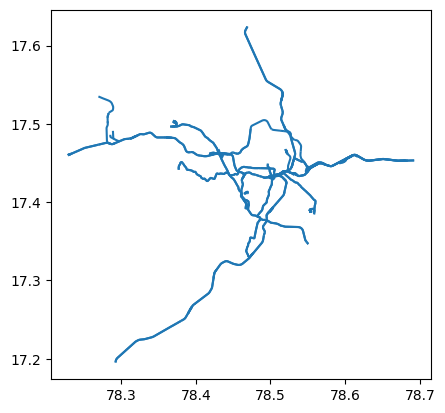

In [ ]:
city = "Hyderabad"
city_df = metro_line_df[metro_line_df['city']==city]
metro_lines = city_df.loc[(public_transport['railway']=='subway')]
print(f"Number of lines: {metro_lines.shape[0]}")
city_df.plot();

Number of stations: 18


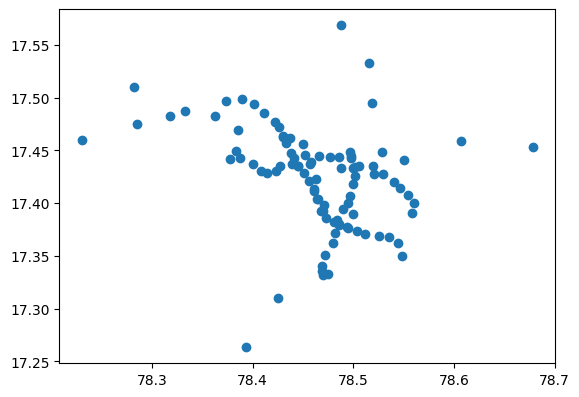

In [ ]:
city_stn_df = metro_station_df[metro_station_df['city']==city]
metro_stns = city_stn_df.loc[(public_transport['railway']=='subway')]
print(f"Number of stations: {metro_stns.shape[0]}")
city_stn_df.plot();

## Export to Parquet files

Once the evaluation of the data is done, export it to parquet format file

In [ ]:
metro_station_df.to_parquet('stations.parquet')
metro_line_df[columns].to_parquet('lines.parquet')